In [1]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

# np.set_printoptions(precision=4, suppress=True)

In [2]:
def getState():
    '''
    Returns the current joint angles and joint angle velocity
    :rtype: np.ndarray, np.ndarray
    '''
    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()
    theta = np.array([q0, q1])
    theta_dot = np.array([q0_dot, q1_dot])
    return theta, theta_dot

def setJointAngles(thetalist):
    '''
    Sets the joint angles of robot
    '''
    assert isinstance(thetalist, np.ndarray) and len(thetalist) == 2
    theta0, theta1 = thetalist[0], thetalist[1]
    
    env.unwrapped.robot.central_joint.reset_position(theta0, 0)
    env.unwrapped.robot.elbow_joint.reset_position(theta1, 0)
    return

def getForwardModel(thetalist):
    '''
    For a 2-dof arm, this function takes joint states thetalist=(q0,q1) as input and returns the 
    end effector position. Units for angles are in radians.
    
    :param thetalist: 1D array containing 2 joint angles
    :type thetalist: np.ndarray
    :rtype: numpy array of size (2,)
    '''
    assert isinstance(thetalist, np.ndarray) and len(thetalist) == 2
    
    l0, l1 = 0.1, 0.11
    theta0, theta1 = thetalist[0], thetalist[1]
    
    x = l0*np.cos(theta0) + l1*np.cos(theta0 + theta1)
    y = l0*np.sin(theta0) + l1*np.sin(theta0 + theta1)
    
    return np.array([x, y])


def getJacobian(thetalist):
    '''
    For a 2-dof arm, this function takes joint states (q0,q1) as input and returns the Jacobian.
    Units for q0, q1 are radians.
    Jacobian calculated in space frame/world frame
    
    :param thetalist: 1D array containing 2 joint angles
    :type thetalist: np.ndarray
    :rtype: numpy array, 2x2
    '''
    assert isinstance(thetalist, np.ndarray)
    assert len(thetalist) == 2

    l0, l1 = 0.1, 0.11
    theta0, theta1 = thetalist[0], thetalist[1]
    
    term1 = -l0*np.sin(theta0) - l1*np.sin(theta0 + theta1)
    term2 = -l1*np.sin(theta0 + theta1)
    term3 = l0*np.cos(theta0) + l1*np.cos(theta0 + theta1)
    term4 = l0*np.cos(theta0 + theta1)
    
    J = np.array([
        [term1, term2],
        [term3, term4],
    ])
    return J

def getIK(dx):
    '''
    Implements inverse kinematics for the 2-dof arm using the Jacobian to map from change 
    in cartesian coordinates to change in joint angles
    
    :param dx: change in posiiton
    :type dx: np.array of size (2,)
    
    :rtype: np.array of size(2,)
    '''
    assert isinstance(dx, np.ndarray) and len(dx) == 2
    
    l0, l1 = 0.1, 0.11

    J = getJacobian(q)
    dq = LA.pinv(J) @ dx
    return dq

def generateTrajectory(numSamples = 1000):
    '''
    Sample points from the parametrix curve to generate desired trajectory
    '''
    assert isinstance(numSamples, int) and numSamples > 0
    steps = (s for s in list(np.linspace(-np.pi, np.pi, num=numSamples)))
    trajectoryPoints = np.zeros((numSamples, 2))
    for i, theta in enumerate(steps):
        x = (0.19 + 0.02*np.cos(4*theta))*np.cos(theta)
        y = (0.19 + 0.02*np.cos(4*theta))*np.sin(theta)
        trajectoryPoints[i,:] = x, y
    return trajectoryPoints

def computeControlAndTorque(J, pos, pos_desired, vel, vel_desired = np.array([0, 0]), Kp = 0.1, Kd = 0.001 ):
    '''
    Returns the torque by computing control signal with error and gain values 
    '''
    proportionalTerm = Kp * np.eye(2) @ (pos_desired - pos)
    diffTerm = Kd * np.eye(2) @ (vel_desired - vel)
    F = proportionalTerm + diffTerm
    torque = J.T @ F
    assert len(torque) == 2
    return torque

def runPDInCartesian(Kp=0.7, Kd=0.2):
    '''
    Runs the PD Controller for Q)1.4 where error signal is measured in end effector coordinates.
    Returns the desired trajectory and the actual trajectory
    '''
    desiredTraj = generateTrajectory(numSamples = 5000)
    actualTraj = np.zeros_like(desiredTraj)
    for i in range(0, len(desiredTraj)):
        theta, theta_dot = getState()
        J = getJacobian(theta)
        pos = getForwardModel(theta)
        vel = J @ theta_dot
        pos_desired = desiredTraj[i,:]
        torque = computeControlAndTorque(J, pos, pos_desired, vel, Kp = Kp, Kd = Kd )
        env.step(torque)
        actualTraj[i,:] = getForwardModel(theta)
    return desiredTraj, actualTraj

def runPDInJointAngles(Kp=0.7, Kd=0.2):
    '''
    Runs the PD Controller for Q)1.5 where error signal is measured in joint angles
    Returns the desired trajectory and the actual trajectory
    '''
    desiredTraj = generateTrajectory(numSamples = 1000)
    actualTraj = np.zeros_like(desiredTraj)
    for i in range(0, len(desiredTraj)):
        theta, theta_dot = getState()
        pos = getForwardModel(theta)
        pos_desired = desiredTraj[i,:]
        J = getJacobian(theta)
        dx = pos_desired - pos
        dq = LA.pinv(J) @ dx
        torque = Kp*(dq) + Kd*(0 - theta_dot)
        env.step(torque)
        actualTraj[i,:] = getForwardModel(theta)
    return desiredTraj, actualTraj

def getMSE(desiredTraj, actualTraj):
    '''
    Calculate mean squared error between two paths
    :rtype: float
    '''
    assert isinstance(desiredTraj, np.ndarray) and isinstance(actualTraj, np.ndarray)
    assert desiredTraj.shape[1] == 2
    assert desiredTraj.shape == actualTraj.shape
    squared_diff = np.sum(np.square(desiredTraj - actualTraj), axis=1)
    return np.mean(squared_diff)

In [3]:
env = gym.make ("ReacherPyBulletEnv-v0")
env.reset()
initial_angle = np.array([-np.pi, 0.0])
setJointAngles(initial_angle)
theta, theta_dot = getState()
print(theta, theta_dot)

current_dir=/Users/adnanshahpurwala/anaconda3/envs/ece276c_venv/lib/python3.6/site-packages/pybullet_envs/bullet
options= 
[-3.14159265  0.        ] [0. 0.]


# PD Controller in end effector coordinates

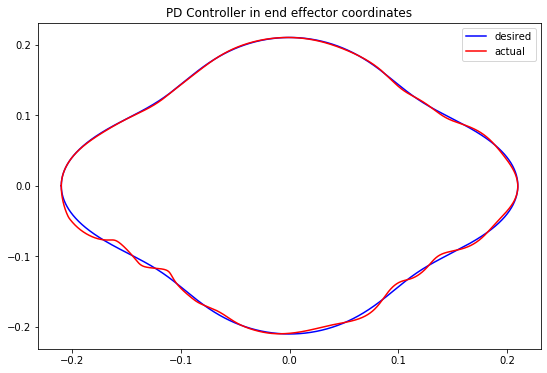

MSE =  8.468949988734487e-06
Gains used --> Kp = 2.4, Kd = 0.15


In [4]:
Kp, Kd = 2.4, 0.15
desiredTraj, actualTraj = runPDInCartesian(Kp, Kd)
plt.figure(figsize=(9,6))
plt.title('PD Controller in end effector coordinates')
plt.plot(desiredTraj[:,0], desiredTraj[:,1],'b')
plt.plot(actualTraj[:,0], actualTraj[:,1], 'r')
plt.legend(('desired','actual'),loc='best')
plt.show()
print('MSE = ', getMSE(desiredTraj, actualTraj))
print('Gains used --> Kp = {0}, Kd = {1}'.format(Kp, Kd))

# PD Controller in end effector coordinates

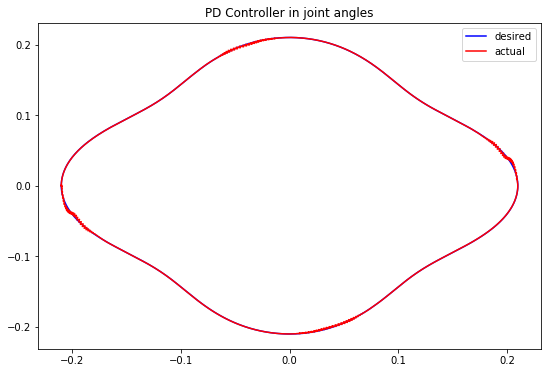

MSE =  4.29363859003678e-06
Gains used --> Kp = 8.0, Kd = 0.18


In [5]:
Kp, Kd = 8.0, 0.18
desiredTraj, actualTraj = runPDInJointAngles(Kp, Kd)
plt.figure(figsize=(9,6))
plt.title('PD Controller in joint angles')
plt.plot(desiredTraj[:,0], desiredTraj[:,1],'b')
plt.plot(actualTraj[:,0], actualTraj[:,1], 'r')
plt.legend(('desired','actual'),loc='best')
plt.show()
print('MSE = ', getMSE(desiredTraj, actualTraj))
print('Gains used --> Kp = {0}, Kd = {1}'.format(Kp, Kd))